# Lab Assignment Two: Exploring Image Data

#### Machine Learning in Python

Will Lacey - 45906124 - <strong>CSE7324</strong>
<br>
Roger Wong - 43867412 - <strong>CSE5324</strong>

## Business Understanding (20 points total).  
<em>
[<strong>20 points</strong>] Give an overview of the dataset. Describe the purpose of the data set you selected (i.e., why was this data collected in the first place?). What is the prediction task for your dataset and which third parties would be interested in the results? Why is this data important? Once you begin modeling, how well would your prediction algorithm need to perform to be considered useful to the identified third parties? Be specific and use your own words to describe the aspects of the data. 
</em>

#### Import Modules and Initialization

Before we begin, let's import essential packages for data analysis

In [9]:
import os
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import seaborn as sns
import matplotlib
from matplotlib import pyplot as plt
from random import randint
from PIL import Image
import skimage.transform
from sklearn.decomposition import PCA
from matplotlib.pyplot import scatter
import cv2 as cv
from skimage.measure import compare_ssim as ssim
from sklearn import preprocessing
from skimage import data, img_as_float

In [10]:
## Data Preparation (10 points total) 


In [11]:
def load_images(class_name, count):
    img_list = []
    for i in range(count):
        img_path_string = 'asl_alphabet/'+class_name+'/'+class_name+str(i+1)+'.jpg'
        img = Image.open(img_path_string) # opens image using PIL
        img = img.convert('L') # grayscales the image
        img = np.asarray(img) # converts image to numpy array
        img = skimage.transform.resize(img, (img_size, img_size), mode='constant') # resizes image
        img_list.append(img)
    return img_list

img_size = 100
class_a = load_images('A', 300)
class_b = load_images('B', 300)
class_c = load_images('C', 300)
class_nothing = load_images('nothing', 100)

print(type(class_a[0]))
print(class_a[0].shape)

<class 'numpy.ndarray'>
(100, 100)


<em>
[<strong>4 points</strong>] Linearize the images to create a table of 1-D image features (each row should be one image).   
</em>

In [12]:
def linearization(class_list):
    for i in range(len(class_list)):
        class_list[i] = class_list[i].flatten()
    return class_list
    
class_a = linearization(class_a)
class_b = linearization(class_b)
class_c = linearization(class_c)
class_nothing = linearization(class_nothing)

print(class_a[0].shape)
print(class_nothing[0].shape)

(10000,)
(10000,)


<em>
[<strong>1 points</strong>] Visualize several images.
</em>

In [13]:
# creating combined class data and class titles

class_list = class_a + class_b + class_c + class_nothing
class_titles = 300*['A'] + 300*['B'] + 300*['C'] + 100*['nothing']
# class_target = 300*[0] + 300*[1] + 300*[2] + 100*[3]

In [14]:
# a similar plotting function as seen in class; selects random images from dataset
def plot_gallery(images, titles, random=True, n_row=3, n_col=6):
    plt.figure(figsize=(1.7 * n_col, 2.3 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        if random:
            index = randint(1, len(images)-1)
        else:
            index = i
        plt.imshow(images[index].reshape((img_size, img_size)), cmap=plt.cm.gray)
        plt.title(titles[index], size=12)
        plt.xticks(())
        plt.yticks(())

        
plot_gallery(class_list, class_titles) 

## Data Reduction (60 points total)

<em>
[<strong>5 points</strong>] Perform linear dimensionality reduction of the images using principal components analysis. Visualize the explained variance of each component. Analyze how many dimensions are required to adequately represent your image data. Explain your analysis and conclusion.
</em>

In [15]:
n_components = 1000
pca = PCA(n_components=n_components)
pca.fit(class_list.copy())
class_list_pca = pca.transform(class_list)

print ('pca:', pca.components_)

pca: [[-6.87195034e-05  2.24587051e-05 -8.74565214e-06 ... -3.93532084e-03
  -3.99955961e-03 -1.92449575e-03]
 [-3.26082997e-05  1.35082806e-05 -3.52806117e-05 ... -2.07444066e-03
  -2.14471385e-03 -1.03521320e-03]
 [ 4.93485767e-05  3.68882863e-05 -1.99899906e-05 ... -8.98320863e-04
  -9.49296358e-04 -4.74264103e-04]
 ...
 [ 4.44707192e-03  4.17216970e-03 -1.05426734e-02 ...  3.28332276e-03
   7.96367611e-03  6.01904685e-03]
 [ 1.96849909e-03  2.78646484e-03 -5.28142283e-04 ... -7.28003114e-03
  -5.93310442e-03 -2.48244084e-04]
 [-9.18857703e-03  1.21356529e-02  1.04641064e-02 ... -5.88540098e-03
  -1.39980255e-02  1.07829994e-02]]


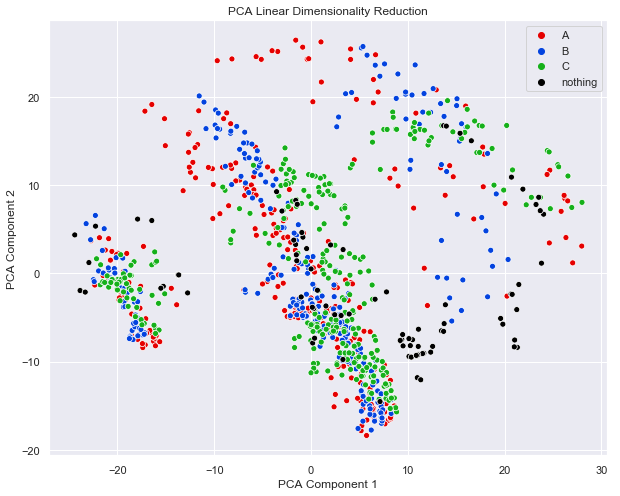

In [16]:
sns.set(style="darkgrid") 
plt.figure(figsize=(10,8))

colors = ['#e50000','#0343df','#15b01a','black']

sns.scatterplot(class_list_pca[:,0], class_list_pca[:,1], hue=class_titles, palette=colors)
plt.title('PCA Linear Dimensionality Reduction')
plt.xlabel('PCA Component 1') 
plt.ylabel('PCA Component 2')
plt.show()

In [17]:
# lets do some PCA of the features and go from 1850 features to 20 features

n_components = 90
pca = PCA(n_components=n_components)
%time pca.fit(class_list.copy())
eigenhands = pca.components_.reshape((n_components, img_size, img_size))

Wall time: 950 ms


In [32]:
# manipulated from Sebastian Raschka Example
# also from hi blog here: http://sebastianraschka.com/Articles/2015_pca_in_3_steps.html

def plot_explained_variance(pca):
    import plotly
    from plotly.graph_objs import Bar, Line
    from plotly.graph_objs import Scatter, Layout
    from plotly.graph_objs.scatter import Marker
    from plotly.graph_objs.layout import XAxis, YAxis
    plotly.offline.init_notebook_mode() # run at the start of every notebook
    
    explained_var = pca.explained_variance_ratio_
    cum_var_exp = np.cumsum(explained_var)
    
    plotly.offline.iplot({
        "data": [Bar(y=explained_var, name='individual explained variance'),
                 Scatter(y=cum_var_exp, name='cumulative explained variance')
            ],
        "layout": Layout(xaxis=XAxis(title='Principal components'), yaxis=YAxis(title='Explained variance ratio'))
    })

plot_explained_variance(pca)

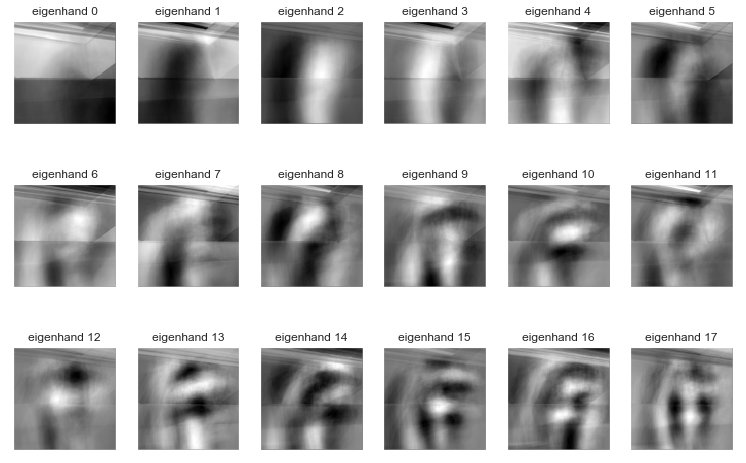

In [31]:
eigenhand_titles = ["eigenhand %d" % i for i in range(eigenhands.shape[0])]
plot_gallery(eigenhands, eigenhand_titles, random=False)

In [30]:
n_components = 190
pca = PCA(n_components=n_components)
pca.fit(class_list.copy())
class_list_pca = pca.transform(class_list)

<em>
[<strong>5 points</strong>] Perform non-linear dimensionality reduction of your image data.
</em>

In [21]:
%%time
from sklearn.decomposition import KernelPCA

n_components = 190

kpca = KernelPCA(n_components=n_components, kernel='rbf', 
                fit_inverse_transform=True, gamma=12, # very sensitive to the gamma parameter,
                remove_zero_eig=True)  
kpca.fit(class_list.copy())
class_list_kpca = kpca.transform(class_list)



Wall time: 1.21 s


<em>
[<strong>20 points</strong>] Compare the representation using non-linear dimensions to using linear dimensions. The method you choose to compare dimensionality methods should quantitatively explain which method is better at representing the images with fewer components. Be aware that mean-squared error may not be a good measurement for kPCA.  Do you prefer one method over another? Why?
</em>

In [22]:
def reconstruct_image(trans_obj,org_features):
    low_rep = trans_obj.transform(org_features)
    rec_image = trans_obj.inverse_transform(low_rep)
    return low_rep, rec_image

In [23]:
kpca_list = []
pca_list = []
n_list = []
S1=0
S2=0
for img in range (len(class_list)): 
    ldm, reconstructed_image = reconstruct_image(pca,class_list[img].reshape(1, -1))
    ldm, kernel_reconstructed_image = reconstruct_image(kpca,class_list[img].reshape(1, -1))
    normal_kpca = preprocessing.normalize(kernel_reconstructed_image.reshape((img_size, img_size)), norm='l2')
    normal_pca = preprocessing.normalize(reconstructed_image.reshape((img_size, img_size)), norm='l2')
    normal_pic = preprocessing.normalize(class_list[img].reshape(img_size, img_size), norm='l2')
    S1+=ssim(normal_pic,normal_pca)
    S2+=ssim(normal_pic,normal_kpca)
    #kpca_list.append(normal_kpca)
    #pca_list.append(normal_pca)
    #n_list.append(normal_pic)

avg_S1 = S1/len(class_list)
avg_S2 = S2/len(class_list)


The average ssim score of the actual image and reconstructed PCA version:  0.9908571005102259
The average ssim score of the actual image and reconstructed Kenrel PCA version:  0.9664057856650196


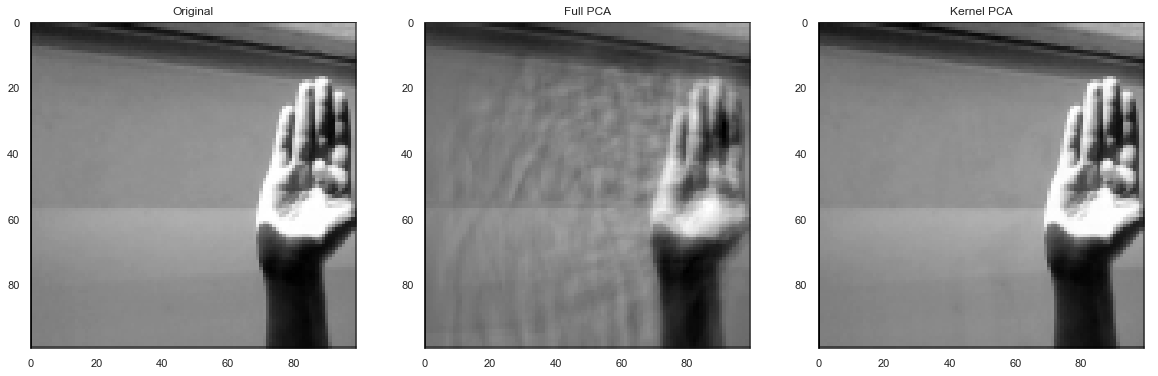

In [24]:
print("The average ssim score of the actual image and reconstructed PCA version: ", avg_S1)
print("The average ssim score of the actual image and reconstructed Kenrel PCA version: ", avg_S2)
LDM, ri = reconstruct_image(pca,class_list[300].reshape(1, -1))
LDM, kri = reconstruct_image(kpca,class_list[300].reshape(1, -1))
plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
plt.imshow(class_list[300].reshape((img_size, img_size)), cmap=plt.cm.gray)
plt.title('Original')
plt.grid()
plt.subplot(1,3,2)
plt.imshow(ri.reshape((img_size, img_size)), cmap=plt.cm.gray)
plt.title('Full PCA')
plt.grid()
plt.subplot(1,3,3)
plt.imshow(kri.reshape((img_size, img_size)), cmap=plt.cm.gray)
plt.title('Kernel PCA')
plt.grid()

<em>
[<strong>10 points</strong>] Perform feature extraction upon the images using any feature extraction technique (e.g., gabor filters, ordered gradients, DAISY, etc.).
</em>

<em>
[<strong>20 points</strong>] Does this feature extraction method show promise for your prediction task? Why? Use visualizations to analyze this questions. For example, visualize the differences between statistics of extracted features in each target class. Another option, use a heat map of the pairwise differences (ordered by class) among all extracted features. Another option, build a nearest neighbor classifier to see actual classification performance.  
</em>

## Exceptional Work (10 points total)

<em>
[<strong>10 points</strong>] Perform feature extraction upon the images using a feature extractor that requires key point matching (such as SIFT/SURF/ORB or others). Then build a nearest neighbor classifier using a method appropriate for your chosen features. You will need to investigate appropriate methods for comparisons with your chosen feature extraction technique. NOTE: this often requires some type of brute force matching per pair of images, which can be computationally expensive).
</em>

In [25]:
orb = cv.ORB_create()

In [27]:
img1 = Image.open('asl_alphabet/A/A1.jpg')
img1 = img1.convert('L') # grayscales the image
img1 = np.asarray(img1) # converts image to numpy array
# img1 = skimage.transform.resize(img1, (img_size, img_size), mode='constant') # resizes image

img2 = Image.open('asl_alphabet/A/A100.jpg')
img2 = img2.convert('L')
img2 = np.asarray(img2) # converts image to numpy array
# img2 = skimage.transform.resize(img2, (img_size, img_size), mode='constant') # resizes image
kp1, des1 = orb.detectAndCompute(img1,None)
kp2, des2 = orb.detectAndCompute(img2,None)

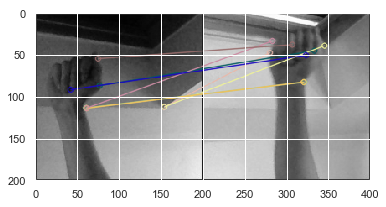

(<matplotlib.image.AxesImage at 0x18489808860>, None)

In [35]:
bf = cv.BFMatcher(cv.NORM_HAMMING, crossCheck=True)
matches = bf.match(des1,des2)
matches = sorted(matches, key = lambda x:x.distance)
img3 = cv.drawMatches(img1,kp1,img2,kp2,matches[:10],None, flags=2)
plt.imshow(img3),plt.show()


In [33]:
class_A = load_images('A', 100)
class_B = load_images('B', 100)
class_C = load_images('C', 100)
class_A = linearization(class_A)
class_B = linearization(class_B)
class_C = linearization(class_C)
class_List = class_A + class_B + class_C + class_nothing
